# Visualization of r-band photometry data for supernova SN2011fe

<IPython.core.display.Javascript object>


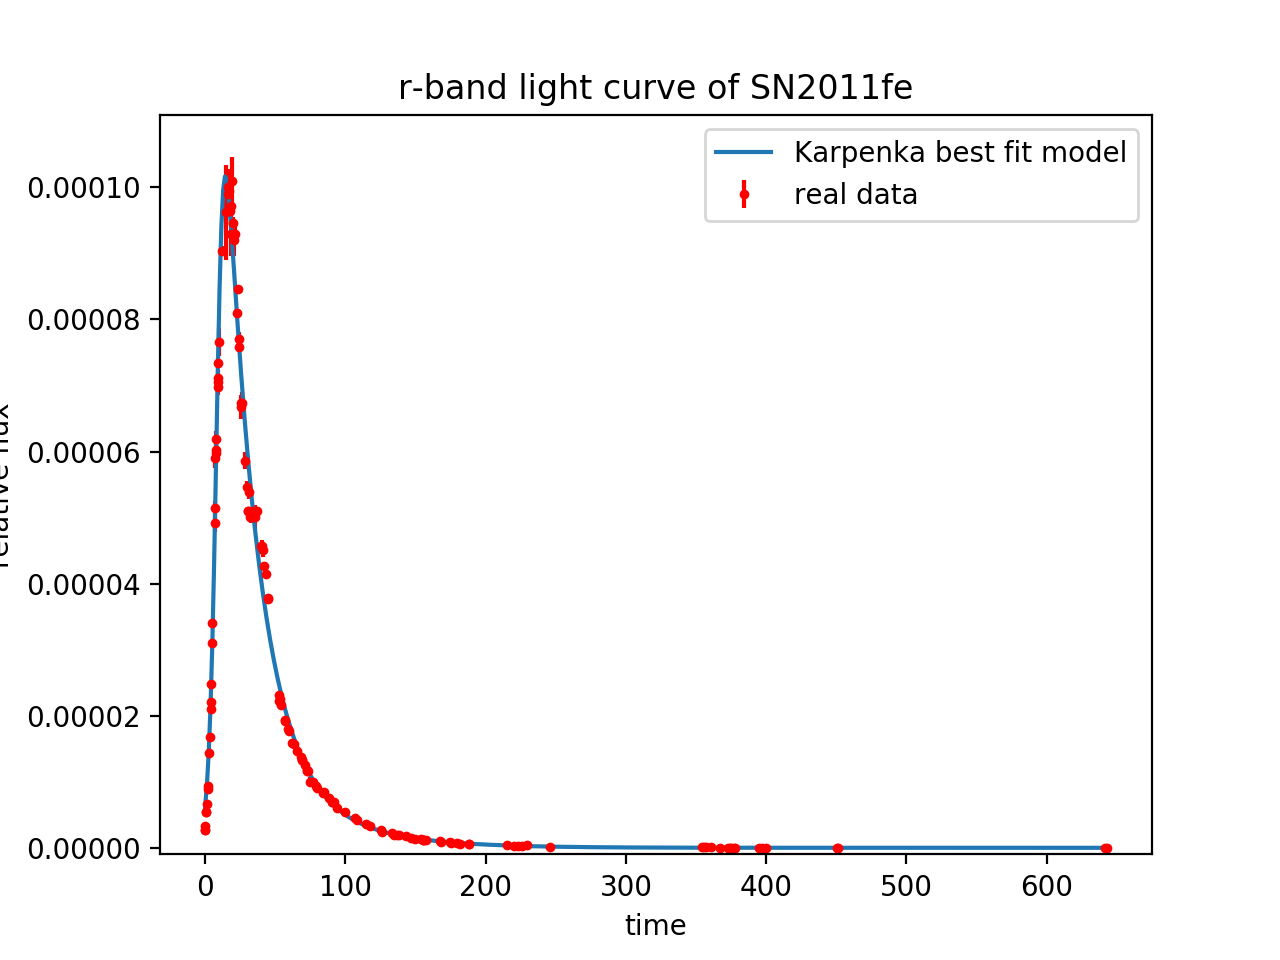

In [30]:
# import relevant python libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
%matplotlib notebook

# open and load the data 
source = open("../../../OSN_data/SN2011fe (1).json")
json_data = json.load(source)

#limit JSON data to just photometry elements
photo_data = json_data['SN2011fe']['photometry'] 

#populate an array of just the R band elements
r_bands = []
for r in range(len(photo_data) - 1):
    if('band' in photo_data[r] and photo_data[r]['band'] == 'R'):
        r_bands.append(photo_data[r])

#create arrays to hold the time and corresponding magnitude and error
magnitudes = []
mag_errors = []
times_ = []


#populate the arrays
for r in r_bands:
    magnitudes.append(float(r['magnitude']))
    mag_errors.append(float(r['e_magnitude']))
    times_.append(float(r['time']))


magnitudes = np.array(magnitudes)
mag_errors = np.array(mag_errors)
times_ = np.array(times_)

#convert magnitudes to flux

flux = 10**(-2*magnitudes / 5) 

#convert magnitude errors to flux errors
mag_max = magnitudes + mag_errors
flux_max = 10**(-2*mag_max / 5)
flux_errors = flux_max - flux


#define Kapernka function to model data
def FitFunc_(t, t_0, A, B, t_1, Tfall, Trise):
	first = A * (1 + (B * (t - t_1)*(t - t_1)))
	var = -(t - t_0)
	second = np.exp(var / Tfall)
	third = 1 + np.exp(var / Trise)
	return first * (second / third)
	
#shift times to start at 0; for curve_fit to function

times_ = times_ - times_[0]


#store priors for the model coefficients
priors = [50, 20, 20, 50, 50, 50]

#find the bestfit coefficients for the Kapenka model
fitCoeffs, Covars = curve_fit(FitFunc_, times_, flux, priors)


#Store the coefficients
bestfit_t = np.linspace(times_[0], times_[-1], 500)
bestfit_t_0 = fitCoeffs[0]
bestfit_A = fitCoeffs[1]
bestfit_B = fitCoeffs[2]
bestfit_t_1 = fitCoeffs[3]
bestfit_Tfall = fitCoeffs[4]
bestfit_Trise = fitCoeffs[5]


#Grab bestfit fluxes
bestfit_flux = FitFunc_(bestfit_t, bestfit_t_0, bestfit_A, bestfit_B, bestfit_t_1, bestfit_Tfall, bestfit_Trise)


#Plot data and bestfit line
plt.errorbar(times_, flux, yerr=flux_errors, color='red', label='real data', fmt = 'o', markersize = 2.5)
plt.plot(bestfit_t, bestfit_flux, label='Karpenka best fit model')
ax = plt.gca()
ax.set_ylim([-0.000001, np.amax(flux) + .00001])
plt.legend()
plt.title('r-band light curve of SN2011fe')
plt.xlabel('time')
plt.ylabel('relative flux')
plt.show()

# K-fold cross validation analysis and root mean squared error calculation

In [44]:
#create array to hold model predicted fluxes
flux_predictions = []

#loop to run 'leave one out' CV
for ind, f in enumerate(flux):
    flux_del = np.delete(flux, ind)
    times_del = np.delete(times_, ind)
    Coeffs, Covar = curve_fit(FitFunc_, times_del, flux_del, fitCoeffs)
    ypred = FitFunc_(times_[ind], Coeffs[0], Coeffs[1], Coeffs[2], Coeffs[3], Coeffs[4], Coeffs[5])
    flux_predictions.append(ypred)

flux_predictions = np.array(flux_predictions)
    
#Root Mean Square Error calculations
dif = flux_predictions - flux
temp = np.sum((flux_predictions - flux)**2)
temp = temp / (len(flux))
RMSE = np.sqrt(temp)
print(RMSE)

    
    

    
    
   
    

2.84706888067e-06
